In [1]:
from hcipy import *
from progressbar import progressbar

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

In [2]:
telescope_diameter = 8. # meter
central_obscuration = 1.2 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.05 # meter
oversizing_factor = 16 / 15

In [3]:
import hcipy

num_pupil_pixels = 240 * oversizing_factor
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

VLT_aperture_generator = hcipy.aperture.make_circular_aperture(telescope_diameter)

VLT_aperture = evaluate_supersampled(VLT_aperture_generator, pupil_grid, 4)

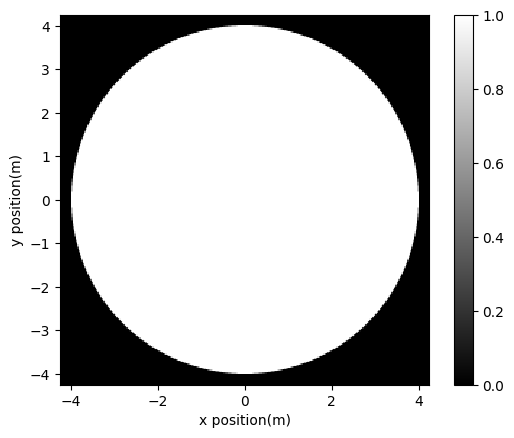

In [4]:
imshow_field(VLT_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

In [5]:
wavelength_wfs = 0.7e-6
wavelength_sci = 2.2e-6
wf = Wavefront(VLT_aperture, wavelength_sci)
wf.total_power = 1

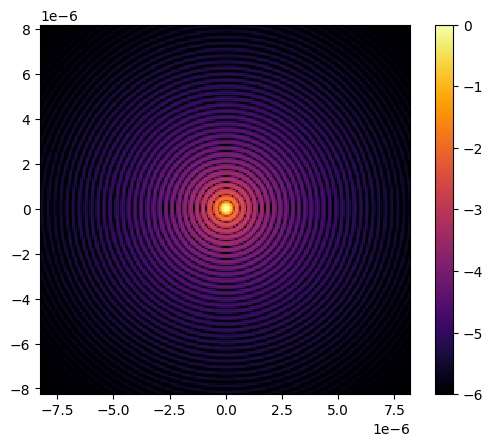

In [6]:
spatial_resolution = wavelength_sci / telescope_diameter
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-6)
plt.colorbar()
plt.show()

In [7]:
camera = NoiselessDetector(focal_grid)

In [9]:
num_modes = 500

# Creating orthogonal modes for correcting.
# Disk harmonic modes with 'neumann' or 'dirichlet' boundary conditions can be tailored 
#    to match the physical constraints of your deformable mirror (DM), such as zero slope or zero value at the edge. 
# Zernike modes are also orthogonal, but only for a perfect, unobstructed, circular pupil.
dm_modes = make_disk_harmonic_basis(pupil_grid, num_modes, telescope_diameter, 'neumann')

In [10]:
# Normalizing each mode with the peak-to-peak value (max - min)
dm_modes = ModeBasis([mode / np.ptp(mode) for mode in dm_modes], pupil_grid)

deformable_mirror = DeformableMirror(dm_modes)

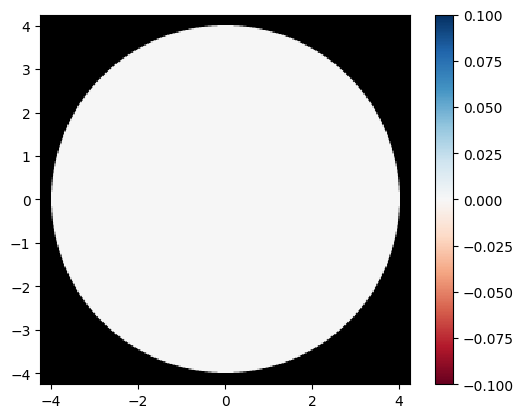

In [299]:
# Put actuators at random values, putting a little more power in low-order modes
deformable_mirror.actuators = np.random.randn(num_modes)  / (np.arange(num_modes) + 10)

# Normalize the DM surface so that we get a reasonable surface RMS.
deformable_mirror.actuators *= 0 * wavelength_sci / np.std(deformable_mirror.surface)

imshow_field(deformable_mirror.phase_for(wavelength_wfs), mask=VLT_aperture, cmap='RdBu')
plt.colorbar()
plt.show()

In [300]:
zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
stellar_magnitude = 5
delta_t = 1e-3 # sec, so a loop speed of 1kHz.

# Real adaptive optics systems often sense the wavefront at one wavelength (visible) and do science at another (infrared).
# This allows you to simulate and compare how well the correction (based on the WFS wavelength) works at the science wavelength, 
#    which is important because the DM correction is not always perfect across all wavelengths (chromatic effects).
wf_wfs = Wavefront(VLT_aperture, wavelength_wfs)
wf_sci = Wavefront(VLT_aperture, wavelength_sci)

wf_wfs.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)
wf_sci.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)

lyot_mask = evaluate_supersampled(circular_aperture(0.95), pupil_grid, 4)

charge = 2
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

C:\Users\alexe\AppData\Local\Temp\ipykernel_28676\2922749714.py:14: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  lyot_mask = evaluate_supersampled(circular_aperture(0.95), pupil_grid, 4)


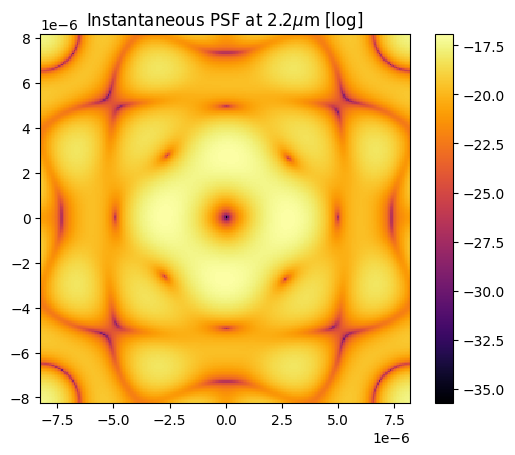

(57600,)
center_color: 0.06439655568506976
strehl: 1.0


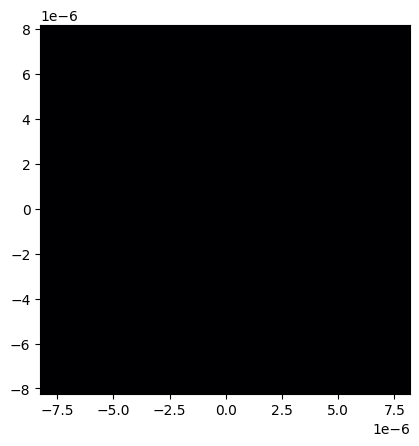

In [302]:
# Propagate the NIR wavefront
wf_sci_after_dm = propagator(lyot_stop(coro(deformable_mirror(wf_sci))))

# Read out WFS camera
camera.integrate(wf_sci_after_dm, delta_t)
wfs_image = camera.read_out()
wfs_image = large_poisson(wfs_image).astype('float')

base = wfs_image

plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
imshow_field(np.log(wf_sci_after_dm.power), cmap='inferno')
plt.colorbar()
plt.show()

wf_aberrated = deformable_mirror(wf_sci)
psf_aberrated = propagator(wf_aberrated).intensity
peak_aberrated = np.max(psf_aberrated)

psf_ideal = propagator(wf_sci).intensity
peak_ideal = np.max(psf_ideal)

strehl = peak_aberrated / peak_ideal

post_lyot_mask = lyot_stop(coro(deformable_mirror(wf_sci)))
img = propagator(post_lyot_mask).intensity
img_ref = propagator(wf_sci).intensity


print(img.shape)

center_pixel_index = (240 // 2) * 240 + 240 // 2
center_pixel = img[center_pixel_index]
print(f"center_color: {center_pixel}")

print(f"strehl: {strehl}")

imshow_field(np.log10(img / img_ref.max()), vmin=-5, vmax=0, cmap='inferno')
plt.show()

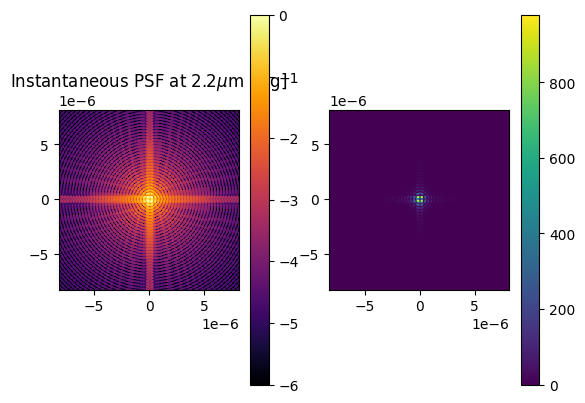

In [296]:
# Propagate the NIR wavefront
wf_sci_after_dm = propagator(coro(deformable_mirror(wf_sci)))

# Read out WFS camera
camera.integrate(wf_sci_after_dm, delta_t)
wfs_image = camera.read_out()
wfs_image = large_poisson(wfs_image).astype('float')

wfs_image -= base
plt.subplot(1, 2, 1)
plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
imshow_field(np.log10(wf_sci_after_dm.power / wf_sci_after_dm.power.max()), vmin=-6, vmax=0, cmap='inferno')
plt.colorbar()
plt.subplot(1,2,2)
imshow_field(wfs_image)
plt.colorbar()
plt.show()

In [218]:
def image_contrast_loss(image):
    """
    Computes a loss value representing the contrast in the image.
    Higher values indicate more spikes/shifts (higher contrast).
    Uses the standard deviation normalized by the mean as a simple contrast metric.
    """
    img = np.asarray(image)
    mean_val = np.mean(img)
    std_val = np.std(img)
    # Avoid division by zero
    if mean_val == 0:
        return std_val
    return std_val / mean_val

# Example usage:
contrast_loss = image_contrast_loss(wfs_image)
print(f"Contrast loss: {contrast_loss}")

Contrast loss: 18.199204806694734
